# Model ResNet

https://www.pluralsight.com/guides/introduction-to-resnet

#### TODOS
1. DONE Debugging, does output make sense?
    1. Resize images
    2. preprocessing fixes
    5. replace scaling by proper function
2. try on leaderboard
3. Include Odometry and fuse into heads
    - Speed
    - Location
4. navigation
5. controller
6. Evaluation on Test set, Modularization



## Dependencies

In [1]:
# MODEL STUFF
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# GENERAL STUFF
import time
import copy
import os
import sys
from tqdm import tqdm

import pandas as pd

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append("../../data_pipeline")
# import data_sampler, dataset
from data_sampler import WeightedSampler
from dataset import CARLADataset #, CARLADatasetMultiProcessing
from utils import train_test_split, create_metadata_df
from fast_dataloader import FastDataLoader

## Model

In [3]:
class MyResnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        
        # ResNet Architecture with pretrained weights, also bigger resnets available
        self.net = torchvision.models.resnet18(pretrained=True) # weights=True
        num_ftrs = self.net.fc.in_features

        # Top layer of ResNet which you can modify. We choose Identity to use it as Input for all the heads
        self.net.fc = nn.Identity()
        
        # Input Layer fuer cmd, spd
        self.cmd_input = nn.Sequential(
            nn.Linear(7, 7),
            nn.LeakyReLU() # TODO
        )
        
        self.spd_input = nn.Sequential(
            nn.Linear(1, 1),
            nn.LeakyReLU() # TODO
        )
        
        # Regression Heads for Throttle, Brake and Steering
        self.thr_head = nn.Sequential(
            nn.Linear(num_ftrs+8, 1),
            nn.Sigmoid() # [0,1] Range Output
        )
        
        self.brk_head = nn.Sequential(
            nn.Linear(num_ftrs+8, 1),
            nn.Sigmoid() # [0,1] Range Output
        )
        
        self.str_head = nn.Sequential(
            nn.Linear(num_ftrs+8, 1),
            nn.Tanh() # [-1,1] Range Output
        )

    # Forward Pass of the Model
    def forward(self, rgb, cmd, spd):
        rgb = self.net(rgb) # BRG
        cmd = self.cmd_input(cmd)
        spd = self.spd_input(spd)
        
        x = torch.cat((rgb, cmd, spd),1)
        
        #x = self.net.fc(x)
        return self.thr_head(x), self.str_head(x), self.brk_head(x) # 3 Outputs since we have 3 Heads

## Data Loaders, Data Sets

In [4]:
# path_data = "../../data/Dataset Ege/Dataset Ege 1"
path_data = os.path.join("..", "..", "data", "data")

# train_path = "../input" #data must be shared publically, doing local for now
# test_path = "../input"

config = {"used_inputs": ["rgb","measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "seq_len": 1
        }

df_meta_data = create_metadata_df(path_data, config["used_inputs"])
df_meta_data_train, df_meta_data_test = train_test_split(df_meta_data, towns={"train": ["Town04"], "test": ["Town05"]}) # "Town06"
# Make test set the 15% of the size of the train set
df_meta_data_test = df_meta_data_test.sample(n=int(df_meta_data_train.shape[0] * 0.15), random_state=3)
# df_meta_data_train, df_meta_data_test = df_meta_data.head(int(258866/120)), df_meta_data.head(int(258866/120))

train_dataset = CARLADataset(root_dir=path_data, df_meta_data=df_meta_data_train, config=config)
test_dataset = CARLADataset(root_dir=path_data, df_meta_data=df_meta_data_test, config=config)

# weighted_sampler = WeightedSampler(dataset=train_dataset)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_dataloader_fast = FastDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader_fast = FastDataLoader(test_dataset, batch_size=batch_size, shuffle=False)


train_dataloader_mp = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader_mp = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [5]:
len(train_dataloader)

952

In [7]:
train_dataset.get_statistics()

,rgb_in_GB,measurements_in_GB,time_hours
0,12.939618,0.267521,8.455278


In [6]:
len(test_dataloader)

143

In [9]:
test_dataset.get_statistics()

,rgb_in_GB,measurements_in_GB,time_hours
0,1.923793,0.040179,1.268194


In [10]:
mean = torch.tensor([79.6657, 81.5673, 105.6161])
std = torch.tensor([66.8309, 60.1001, 66.2220])


transform_norm = transforms.Compose([
    transforms.Normalize(mean, std)
])


## Training

In [11]:
# Initialise Model (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
print(device)
net = MyResnet()
net.to(device)

mps


/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyResnet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [12]:
def to_cuda_if_possible(data):
    return data.to(device) if device else data

In [13]:
def forward_pass(data):
    # further preprocessing
    start_prep = time.time()
    X_rgb = torch.squeeze(transform_norm(data["rgb"])).float()
    labels = data["command"]
    # labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0
    labels = torch.where(labels == -1, torch.tensor(0, dtype=labels.dtype), labels).to(torch.int64) # Replace by -1 by 0
    # Convert the labels to a one hot encoded tensor
    one_hot = torch.nn.functional.one_hot(labels, num_classes=7)
    X_cmd = torch.squeeze(one_hot).float()
    X_spd = ((data["speed"]-speed_mean)/speed_std).float()
    
    Y_throttle = data["throttle"].float()
    Y_steer = data["steer"].float()
    Y_brake = data["brake"].float()
    end_prep = time.time()
    time_prep = end_prep - start_prep
    # move to GPU
    start_trans_cuda = time.time()
    X_rgb = to_cuda_if_possible(X_rgb)
    X_cmd = to_cuda_if_possible(X_cmd)
    X_spd = to_cuda_if_possible(X_spd)
    
    Y_throttle = to_cuda_if_possible(Y_throttle)
    Y_steer = to_cuda_if_possible(Y_steer)
    Y_brake = to_cuda_if_possible(Y_brake)
    end_trans_cuda = time.time()
    time_trans_cuda = end_trans_cuda - start_trans_cuda
    # compute outputs
    start_forward = time.time()
    optimizer.zero_grad()
    Y_hat = net(X_rgb, X_cmd, X_spd)
    end_forward = time.time()
    time_forward = end_forward - start_forward
    start_trans_cuda_2 = time.time()
    Y_hat_throttle = to_cuda_if_possible(Y_hat[0])
    Y_hat_steer = to_cuda_if_possible(Y_hat[1])
    Y_hat_brake = to_cuda_if_possible(Y_hat[2])

    # get labels from data
    Y_throttle = to_cuda_if_possible(data["throttle"].float())
    Y_steer = to_cuda_if_possible(data["steer"].float())
    Y_brake = to_cuda_if_possible(data["brake"].float())
    end_trans_cuda_2 = time.time()
    time_trans_cuda_2 = end_trans_cuda_2 - start_trans_cuda_2

    # Calculate Loss
    start_loss = time.time()
    loss_throttle = criterion(Y_hat_throttle, Y_throttle) # 0.7*
    loss_steer = criterion(Y_hat_steer, Y_steer) # 0.2
    loss_brake = criterion(Y_hat_brake, Y_brake) # 0.1
    loss = sum([loss_throttle, loss_steer, loss_brake]) / 3
    end_loss = time.time()
    time_loss = end_loss - start_loss
    return loss_throttle, loss_steer, loss_brake, loss, time_prep, time_trans_cuda, time_forward, time_trans_cuda_2, time_loss

In [14]:
# Loss and Optimizer
criterion = nn.L1Loss() # Easy to interpret #nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) #optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Model Trainer Prototype

In [15]:
"""
Checking time consumption in training pipeline:
- Data Loading: cannot directly measure it because done in for loop itself and other stuff in for loop
- Data Preprocessing
- Training step
- Validation step

"""

'\nChecking time consumption in training pipeline:\n- Data Loading: cannot directly measure it because done in for loop itself and other stuff in for loop\n- Data Preprocessing\n- Training step\n- Validation step\n\n'

In [16]:
speed_mean = 2.250456762830466
speed_std = 0.30215840254891313

In [17]:
times_prep, times_trans_cuda, times_forward, times_trans_cuda_2, times_loss, times_backprop, times_val, times_epoch, times_monitoring = [], [], [], [], [], [], [], [], []

In [18]:
%%time

n_epochs = 2
print_every = 200
valid_loss_min = np.Inf
total_step = len(train_dataloader)
val_loss = []

train_loss, train_loss_throttle, train_loss_brake, train_loss_steer = [], [], [], []
val_loss, val_loss_throttle, val_loss_brake, val_loss_steer = [], [], [], []

validate = True

for epoch in range(1, n_epochs+1):
    start_epoch = time.time()
    
    running_loss, running_loss_throttle, running_loss_steer, running_loss_brake = 0.0, 0.0, 0.0, 0.0

    print(f'Epoch {epoch}\n')
    
    # Work through batches
    for batch_idx, data in enumerate(train_dataloader):
        
        loss_throttle, loss_steer, loss_brake, loss, time_prep, time_trans_cuda, time_forward, time_trans_cuda_2, time_loss = forward_pass(data)

        times_prep.append(time_prep)
        times_trans_cuda.append(time_trans_cuda)
        times_forward.append(time_forward)
        times_trans_cuda_2.append(time_trans_cuda_2)
        times_loss.append(time_loss)

        start_backprop = time.time()
        # Backprop
        loss.backward()
        optimizer.step()
        end_backprop = time.time()
        time_backprop = end_backprop - start_backprop
        times_backprop.append(time_backprop)
        
        start_monitoring = time.time()

        running_loss += loss.item()
        running_loss_throttle += loss_throttle.item()
        running_loss_steer += loss_steer.item()
        running_loss_brake += loss_brake.item()

        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item())) # running_loss_list[-1]# loss.item()
        end_monitoring = time.time()
        time_monitoring = end_monitoring - start_monitoring
        times_monitoring.append(time_monitoring)
        
    # Epoch finished, evaluate network and save if network_learned
    train_loss.append(running_loss/total_step)
    train_loss_throttle.append(running_loss_throttle/total_step)
    train_loss_brake.append(running_loss_brake/total_step)
    train_loss_steer.append(running_loss_steer/total_step)




    # print(f'\ntrain-loss: {np.mean(train_loss):.4f},') # TODO SOLVE NAN ISSUES
    print(f'\ntrain-loss: {np.mean(train_loss):.4f},') # TODO SOLVE NAN ISSUES
    batch_loss, batch_loss_brake, batch_loss_steer, batch_loss_throttle = 0, 0, 0, 0

    start_val = time.time()
    if validate:
        with torch.no_grad():
            net.eval()
            
            for batch_idx, data in enumerate(test_dataloader):
                
                loss_throttle, loss_steer, loss_brake, loss, time_prep, time_trans_cuda, time_forward, time_trans_cuda_2, time_loss = forward_pass(data)
                
                batch_loss += loss.item()
                batch_loss_brake += loss_brake.item()
                batch_loss_steer += loss_steer.item()
                batch_loss_throttle += loss_throttle.item()
            val_loss.append(batch_loss/len(test_dataloader))
            val_loss_throttle.append(batch_loss_throttle / len(test_dataloader))
            val_loss_brake.append(batch_loss_brake / len(test_dataloader))
            val_loss_steer.append(batch_loss_steer / len(test_dataloader))
            #network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, \n') # TODO SOLVE NAN ISSUES

            
            if False:#network_learned:
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), 'resnet.pt')
                print('Improvement-Detected, save-model')
    end_val = time.time()
    time_val = end_val - start_val
    times_val.append(time_val)

    # Back to training
    net.train()
    end_epoch = time.time()
    time_epoch = end_epoch - start_epoch
    times_epoch.append(time_epoch)
    
    

Epoch 1



/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/10], Step [0/952], Loss: 0.3645
Epoch [1/10], Step [200/952], Loss: 0.1633
Epoch [1/10], Step [400/952], Loss: 0.1298
Epoch [1/10], Step [600/952], Loss: 0.1553
Epoch [1/10], Step [800/952], Loss: 0.1236

train-loss: 0.1450,
validation loss: 0.1670, 

Epoch 2

Epoch [2/10], Step [0/952], Loss: 0.1135
Epoch [2/10], Step [200/952], Loss: 0.1292
Epoch [2/10], Step [400/952], Loss: 0.1463
Epoch [2/10], Step [600/952], Loss: 0.1130
Epoch [2/10], Step [800/952], Loss: 0.1075

train-loss: 0.1322,
validation loss: 0.1707, 

Epoch 3

Epoch [3/10], Step [0/952], Loss: 0.1006
Epoch [3/10], Step [200/952], Loss: 0.1286
Epoch [3/10], Step [400/952], Loss: 0.1187
Epoch [3/10], Step [600/952], Loss: 0.1094
Epoch [3/10], Step [800/952], Loss: 0.0954

train-loss: 0.1247,
validation loss: 0.1740, 

Epoch 4

Epoch [4/10], Step [0/952], Loss: 0.1246
Epoch [4/10], Step [200/952], Loss: 0.0990
Epoch [4/10], Step [400/952], Loss: 0.1166
Epoch [4/10], Step [600/952], Loss: 0.1021
Epoch [4/10], Step [

In [19]:
torch.save(net, f"rgb_resnet_num_epochs_{n_epochs}.pth")

In [22]:
import pandas as pd

In [23]:
def get_speed_stats():
    df_speed_stats = pd.DataFrame({
    "times_prep" : times_prep, 
    "times_trans_cuda" : times_trans_cuda, 
    "times_forward": times_forward, 
    "times_trans_cuda_2" : times_trans_cuda_2, 
    "times_loss" : times_loss, 
    "times_backprop" : times_backprop, 
    "times_monitoring" : times_monitoring, 
    })
    df_speed_stats = df_speed_stats.sum().to_frame().T
    df_speed_stats["time_val"] = times_val[0]
    df_speed_stats["time_untracked"] = times_epoch[0] - df_speed_stats.sum().sum()
    df_speed_stats = df_speed_stats.T
    df_speed_stats.columns = ["time_sec"]
    df_speed_stats["time_%"] = (df_speed_stats["time_sec"] / df_speed_stats["time_sec"].sum() * 100).round(2)
    df_speed_stats = df_speed_stats.sort_values(by="time_%", ascending=False)
    return df_speed_stats

In [24]:
df_speed_stats = get_speed_stats()
df_speed_stats

,time_sec,time_%
times_monitoring,8064.826671,361.17
times_trans_cuda_2,3285.345459,147.13
times_backprop,2439.619126,109.25
times_prep,561.060480,25.13
times_trans_cuda,187.988427,8.42
time_val,165.879376,7.43
times_forward,83.774568,3.75
times_loss,7.838608,0.35
time_untracked,-12563.337614,-562.62


In [29]:
def get_performance_stats():
    df_performance_stats = pd.DataFrame({
    "train_loss" : train_loss, 
    "train_loss_throttle" : train_loss_throttle, 
    "train_loss_brake": train_loss_brake, 
    "train_loss_steer" : train_loss_steer,
    "val_loss" : val_loss, 
    "val_loss_throttle" : val_loss_throttle, 
    "val_loss_brake" : val_loss_brake,
    "val_loss_steer" : val_loss_steer 
    })
    return df_performance_stats

In [33]:
df_performance_stats = get_performance_stats()
df_performance_stats.to_pickle(f"df_perf_rgb_resnet_num_epochs_{n_epochs}.pkl")

In [34]:
df_performance_stats

,train_loss,train_loss_throttle,train_loss_brake,train_loss_steer,val_loss,val_loss_throttle,val_loss_brake,val_loss_steer
0,0.144957,0.272432,0.090603,0.071835,0.166976,0.289390,0.151427,0.060111
1,0.119412,0.250508,0.051389,0.056338,0.174437,0.307343,0.169359,0.046609
2,0.109823,0.235249,0.040708,0.053512,0.180495,0.315325,0.180185,0.045975
3,0.101450,0.218124,0.033847,0.052379,0.171151,0.305843,0.158977,0.048634
4,0.091394,0.193178,0.029718,0.051286,0.156636,0.292263,0.130551,0.047094
5,0.080550,0.165107,0.026660,0.049884,0.172831,0.311104,0.160992,0.046396
6,0.068827,0.134828,0.023050,0.048604,0.184618,0.329610,0.178904,0.045339
7,0.060226,0.111745,0.021278,0.047655,0.180785,0.326003,0.170349,0.046003
8,0.053046,0.093736,0.018790,0.046611,0.181056,0.317172,0.176139,0.049858
9,0.048785,0.082414,0.018689,0.045253,0.182730,0.328663,0.173026,0.046501


<AxesSubplot: xlabel='Epoch', ylabel='Mean L1 Loss'>

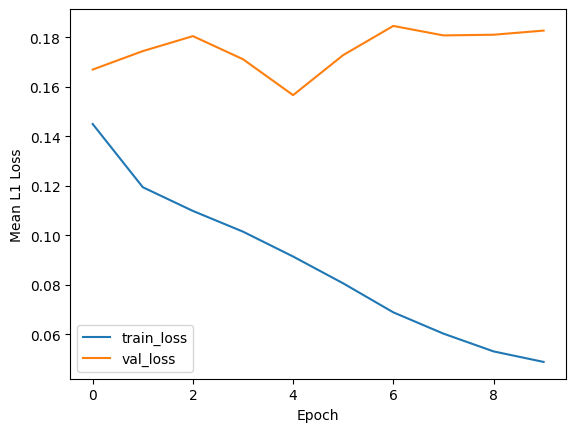

In [49]:
df_performance_stats[["train_loss", "val_loss"]].plot(xlabel="Epoch", ylabel="Mean L1 Loss",)

In [23]:
df_speed_stats.to_pickle("df_speed_stats_benchmark.pkl")

In [ ]:
# after 16 min 400/1514 batches are finished --> ~ 74min for an epoch (Town 04/05)
# 56GB (entire set as Moritz trained)/ (20GB train set --> Town04/05): 2.8 * 74min = 207 min (3.5 hours)


### Test predictions

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
iterator = iter(test_dataloader)
#print(next(iter(test_dataloader)).keys())

In [ ]:
data = next(iterator)
#data

In [ ]:
X_rgb = torch.squeeze(transform_norm(data["rgb"])).float().to(device)
labels = data["command"]
labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0
# Convert the labels to a one hot encoded tensor
one_hot = torch.nn.functional.one_hot(labels, num_classes=7).to(device)
X_cmd = torch.squeeze(one_hot).float().to(device)
X_spd = ((data["speed"]-speed_mean)/speed_std).float().to(device)

target_ = (data["throttle"], data["steer"], data["brake"])
with torch.no_grad():
    net.eval()
    outputs_ = net(X_rgb, X_cmd, X_spd)

In [ ]:
# Durchschnittlicher abs. fehler
for i in [0,1,2]:
    print(np.mean(abs(outputs_[i].cpu().numpy()-target_[i].cpu().numpy())))

Bias Variance

In [ ]:
# Variance 

for i in [0,1,2]:
    outputs = (outputs_[i].cpu().numpy())
    #print(outputs)
    mean_outputs = np.mean(outputs_[i].cpu().numpy())
    #print(mean_outputs)
    diff = (outputs-mean_outputs)**2
    #print(diff)
    value = np.mean(diff)
    print(value)

In [ ]:
# Bias
for i in [0,1,2]:
    targets = (target_[i].cpu().numpy())
    #print(outputs)
    mean_outputs = np.mean(outputs_[i].cpu().numpy())
    #print(mean_outputs)
    diff = outputs-mean_outputs
    #print(diff)
    value = np.mean(diff)
    print(value)

In [ ]:
"""
for i in [0,1,2]:
    print(np.mean(abs(target_[i].cpu().numpy())))
    print(np.std(abs(target_[i].cpu().numpy())))
"""

In [ ]:
i =0

In [ ]:
print(np.round(outputs_[i].cpu().numpy(),1))

In [ ]:
print(np.round(target_[i].cpu().numpy(),1))

### IMG Processing

BGR is now standard FOR carla agent and training

In [ ]:
import cv2
idx, batch = next(enumerate(test_dataloader))
print(batch["rgb"].shape)

In [ ]:
img = batch["rgb"][0]#.shape
img = img.numpy().astype(np.uint8).reshape(160,960,3)
print(img.shape)

#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # NUR HIER, NICHT IN CARLA AGENT
print(img.shape)
print(type(img))
transform = transforms.Compose([transforms.ToPILImage()])

tensor = transform(img)

#print(type(tensor))

tensor.show()

#torch.tensor(tensor)

TEST Normalization

In [ ]:
tensor = transform_norm(torch.squeeze(data["rgb"],1))

In [ ]:
tensor = torch.squeeze(transform_norm(data["rgb"])).float()

In [ ]:
for i in range(64):
    print(np.mean(tensor.numpy()[i], axis = (1,2)))

In [ ]:
np.mean(tensor.numpy(), axis = (0,2,3))

### adding Navigation and speed

In [ ]:
test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
iterator = iter(test_dataloader)



In [ ]:
data = next(iterator)
#data["speed"]
#data["command"]

Command

In [ ]:
import torch

# Assume labels is a 1D tensor with values from 0 to 6

labels = data["command"]
labels = torch.where(labels == -1, torch.tensor(0), labels) # Replace by -1 by 0
labels = labels.to(torch.int64)

# Convert the labels to a one hot encoded tensor
one_hot = torch.nn.functional.one_hot(labels, num_classes=7)
one_hot = torch.squeeze(one_hot)

print(one_hot.shape)

Speed

In [ ]:
# calc mean over trainingsset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataloader))
iterator = iter(train_dataloader)

In [ ]:
i = 0
summe = []
for batch_idx, data in enumerate(train_dataloader):
    #print(data)
    if i % 100 == 0:
        print(i)
    summe.append(np.mean(data["speed"].numpy()))
    if i >= 1000:
        break
    i += 1


In [ ]:
#print(summe)

In [ ]:
print(np.mean(summe)) # 2.2078979146598274
print(np.std(summe)) # 0.22455625005948113
speed_mean = np.mean(summe)
speed_std = np.std(summe)

In [ ]:
batch = next(iterator)
#print(np.round(batch["speed"].numpy(),2))

In [ ]:
(batch["speed"]-speed_mean)/speed_std

### Vanishing/Exploding Gradients

In [ ]:
"""
for name, param in net.thr_head.named_parameters():
    if param.requires_grad:
        print(name, param.data.cpu().numpy())
"""

In [ ]:
for name, param in net.spd_input.named_parameters():
    if param.requires_grad:
        print(name, np.max(abs(param.data.cpu().numpy())))

## Saving and Loading

Not suited for leaderboard agents

In [ ]:
#torch.save(net, 'rgb_resnet.pth')

In [ ]:
#net = torch.load('rgb_resnet.pth')

suited for leaderboard agents

In [ ]:
#torch.save(net.state_dict(), "rgb_resnet_cmd_spd.pth")

In [ ]:
#net = MyResnet()
#net.load_state_dict(torch.load("rgb_resnet_cmd_spd.pth"))
#net.cuda()

## Testing Time

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
idx, X = next(enumerate(test_dataloader))
img = transform_norm(X["rgb"])
img.shape

In [ ]:
torch.squeeze(img,1).shape

In [ ]:
# ohne preprocessing ca 16-17 sekunden. Mit preprocessing ca 37 sekunden ~2gb
# 24.12: 44 batches -> preprocessing 26 sec, training & preprocessing 69 sec
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(len(test_dataloader))
at = time.time()
for batch_idx, data in enumerate(test_dataloader):
    #print(batch_idx)
    data_ = torch.squeeze(transform_norm(data["rgb"]),1).float()
    #print(data_.shape)
et = time.time()
print(et-at)
